# Generating Hypothetical Triples Through Reasoning Paths
Query-to-Hypothetical-Triples: Deriving reasoning paths in triple form from queries for knowledge graph alignment


In [ ]:
import pandas as pd
import logging
import time
from openai import OpenAI
import re

# Configuration
EXCEL_PATH = "../data/MSE-KG/KG_QA/Competency_Question.xlsx"
OUTPUT_EXCEL_PATH = "../data/MSE-KG/MyRAG/HypoTriples_up2.xlsx"

# Initialize OpenAI client
client = OpenAI(api_key=API_KEY, base_url="https://api.deepseek.com")

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

PROMPT_TEMPLATE = """
Task: For a given user question, analyze step-by-step and generate reasoning paths that meet the following conditions:

1. Output Format: Multiple triplets, using parentheses to mark entities/classes → (Head Entity/Class, Relation, Tail Entity/Class)
2. Class Constraints: Classes are allowed as bridging nodes in the path.
3. Path Quantity: Maximum of 2 distinct reasoning paths must be generated.

**Processing Guidelines**  
- Path Completion: If a direct relation is missing, insert a class constraint as an intermediate node.  
- Direction Control: Relation arrows must align with semantic logic  
- Dynamic Length: Path length adapts to question complexity.  
- Prioritization: If multiple valid paths exist, select the 2 most semantically complete and logically concise paths.


**Examples**  

**Example 1 (Single-hop Question)**  
**Question**: *"Who is the director of the movie 'Inception'?"*  
**Reasoning Path**:  
    (Person, is director of, Inception)
    (Inception, directed by, Director)


    
**Example 2 (Multi-hop Question)**  
**Question**: *"Which researcher from MIT published the dataset 'Nano2023' cited in 'Advanced Materials Lecture 5'?"*  
**Reasoning Path**:  
# Path 1: From MIT to Citation  
(MIT, has affiliation, Researcher)  
(Researcher, published, Nano2023)  
(Advanced Materials Lecture 5, cites, Nano2023)  

# Path 2: From Citation to MIT  
(Advanced Materials Lecture 5, cites, Nano2023)  
(Nano2023, published by, MIT)  
(MIT, employs, Researcher) 

**Question**: {question}

"""

def generate_answer(question):
    """Generate API response with retries"""
    prompt = PROMPT_TEMPLATE.format(question=question)
    
    for attempt in range(3):
        try:
            response = client.chat.completions.create(
                model="deepseek-chat",
                messages=[
                    {"role": "system", "content": "You are a knowledge graph expert specialized in extracting structured relationships."},
                    {"role": "user", "content": prompt}],
                temperature=0.1,      # Controls randomness (lower = more deterministic)
                max_tokens=1024,      # Maximum response length
                seed=42              # Random seed for reproducibility (if supported)
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            logging.warning(f"Attempt {attempt+1}/3 failed: {str(e)}")
            time.sleep(1 + attempt*2)
    return ""

def extract_triples(text):
    """Extract full triples with nested parentheses using bracket counting"""
    triples = []
    stack = []
    current = ""
    
    for char in text:
        if char == '(':
            stack.append(char)
            current += char
        elif char == ')':
            if stack:
                stack.pop()
                current += char
                if not stack:
                    # Full triple collected
                    if current.count(',') == 2:
                        triples.append(current.strip())
                    current = ""
            else:
                current = ""  # reset in case of malformed structure
        elif stack:
            current += char
    return triples


def process_questions():
    """Main processing workflow"""
    try:
        df = pd.read_excel(EXCEL_PATH, engine='openpyxl')
        questions = df.iloc[:, 0].tolist()
    except Exception as e:
        logging.error(f"Failed to read Excel file: {str(e)}")
        return

    results = []
    
    for idx, question in enumerate(questions, 1):
        logging.info(f"Processing {idx}/{len(questions)}: {question[:50]}...")
        raw_response = generate_answer(question)
        print(f"Raw Response: {raw_response}")
        reasoning_triples = extract_triples(raw_response)
        
        results.append({
            "Original Question": question,
            "Raw Response": raw_response,
            "Reasoning Path": "\n".join(reasoning_triples) if reasoning_triples else "N/A"
        })
    
    try:
        result_df = pd.DataFrame(results)
        # Merge with original dataframe while preserving existing columns
        final_df = pd.concat([df, result_df[["Raw Response", "Reasoning Path"]]], axis=1)
        final_df.to_excel(OUTPUT_EXCEL_PATH, index=False, engine='openpyxl')
        logging.info(f"Results saved to {OUTPUT_EXCEL_PATH}")
    except Exception as e:
        logging.error(f"Failed to save results: {str(e)}")

if __name__ == "__main__":
    process_questions()

# Constructing an Offline Vector Database for Embedded Triples

In [ ]:
import numpy as np
import faiss
import json
import logging
from sentence_transformers import SentenceTransformer

TRIPLES_PATH = "../data/MSE-KG/KGPreprocess/triples_original.txt"
INDEX_PATH = "../data/MSE-KG/MyRAG/Faiss_Index_N.index"
META_PATH = "../data/MSE-KG/MyRAG/FactualTriples_N.json"

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def preprocess_triples(triple_line):
    """Process a triple line by removing parentheses and splitting into components"""
    line = triple_line.strip().strip("()")
    if line.endswith('.'):
        line = line[:-1].strip()
    parts = [part.strip() for part in line.split(", ", 2)]
    return parts if len(parts) == 3 else None

def build_vector_db():
    """Build a vector database from knowledge graph triples"""
    # Load and preprocess raw triples
    valid_triples = []
    with open(TRIPLES_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            if parts := preprocess_triples(line):
                valid_triples.append("\t".join(parts))
    
    # Generate embeddings
    model = SentenceTransformer("BAAI/bge-m3")
    embeddings = model.encode(valid_triples, convert_to_tensor=False)
    embeddings = np.array(embeddings).astype("float32")

    # Create FAISS index
    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings)
    
    # Save index and metadata
    faiss.write_index(index, INDEX_PATH)
    with open(META_PATH, 'w') as f:
        json.dump({"triples": valid_triples}, f)
    
    logging.info(f"Successfully built index! Saved to: {INDEX_PATH}")

if __name__ == "__main__":
    build_vector_db()

# Online Alignment of Hypothetical and Factual Triplets in Vector Space

In [ ]:
# Core Steps!
import pandas as pd
import numpy as np
import faiss
import json
import os
import logging
import re
from sentence_transformers import SentenceTransformer

INDEX_PATH = "../data/MSE-KG/MyRAG/Faiss_Index_N.index"
META_PATH = "../data/MSE-KG/MyRAG/FactualTriples_N.json"
INPUT_EXCEL = "../data/MSE-KG/MyRAG/HypoTriples_up2.xlsx"
OUTPUT_EXCEL = "../data/MSE-KG/MyRAG/FactualTriples_up2.xlsx"

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class TriplesMatcher:
    def __init__(self):
        """Initialize the triples matcher with FAISS index and metadata"""
        self.index = faiss.read_index(INDEX_PATH)
        with open(META_PATH) as f:
            self.metadata = json.load(f)["triples"]
        self.model = SentenceTransformer("BAAI/bge-m3", device='cpu')
    
    def parse_input_triples(self, raw_str):
        """Enhanced triple parser with robust pattern matching"""
        if pd.isna(raw_str) or "#VALUE!" in raw_str:
            return []
        
        # Use regex to extract all possible triples
        pattern = r"\(([^)]+)\)"
        matches = re.findall(pattern, raw_str)
        
        parsed_triples = []
        for match in matches:
            try:
                # Clean each match
                clean_match = match.strip('"\' ')
                parts = [p.strip() for p in clean_match.split(",", 2)]  # Allow comma separation
                if len(parts) == 3:
                    parsed_triples.append("\t".join(parts))
            except Exception as e:
                logging.warning(f"Parsing failed: {match} | Error: {str(e)}")
        return parsed_triples
    
    def search_similar(self, query_triple, top_k=100):
        """Similarity search with error handling"""
        try:
            query_embed = self.model.encode(query_triple, 
                                          convert_to_tensor=False, 
                                          show_progress_bar=False)
            query_embed = np.array(query_embed).astype("float32").reshape(1, -1)
            scores, indices = self.index.search(query_embed, top_k)
            return [
                {"triple": self.metadata[i], "score": float(s)}
                for i, s in zip(indices[0], scores[0])
            ]
        except Exception as e:
            logging.error(f"Search failed: {query_triple} | Error: {str(e)}")
            return []

def main():
    """Main execution function"""
    matcher = TriplesMatcher()
    top_k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    df_original = pd.read_excel(INPUT_EXCEL)

    for top_k in top_k_list:
        df = df_original.copy()
        results = []

        for idx, row in df.iterrows():
            raw_triples = row["Reasoning Path"]
            parsed_triples = matcher.parse_input_triples(raw_triples)

            all_matches = []
            for triple in parsed_triples:
                matches = matcher.search_similar(triple, top_k=top_k)
                for m in matches:
                    triple_parts = m["triple"].split("\t")
                    if len(triple_parts) == 3:
                        s, p, o = triple_parts
                        formatted = f"({s}, {p}, {o}) (Score: {m['score']:.2f})"
                        all_matches.append(formatted)

            results.append("\n".join(all_matches) if all_matches else "#VALUE!")

        df["Factual Triples"] = results
        output_file = OUTPUT_EXCEL.replace(".xlsx", f"_top{top_k}.xlsx")
        df.to_excel(output_file, index=False)
        logging.info(f"top_k={top_k} processing completed! Results saved to {output_file}")


if __name__ == "__main__":
    main()

In [ ]:
# # Processing the top_k versions of the triples
import os
import re
import pandas as pd
BASE_INPUT_PATH = "../data/MSE-KG/MyRAG/FactualTriples_up2_top"
OUTPUT_DIR = "../data/MSE-KG/"
TOP_K_LIST = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
TARGET_COLUMN = "Factual Triples"
OUTPUT_COLUMN = "Cleaned Triples"

def clean_possible_triples(text):
    if pd.isna(text):
        return ""

    cleaned_lines = []
    for line in str(text).strip().splitlines():
        # 去除 (Score: x.xx)
        line = re.sub(r'\s*\(Score:\s*\d+\.\d+\)', '', line)
        # 去除三元组内的尖括号
        line = re.sub(r'<([^<>]+)>', r'\1', line)
        cleaned_lines.append(line)

    return '\n'.join(cleaned_lines)



def process_excel_file(input_path, output_path):
    """Process Excel file: clean triples and save to new file"""
    df = pd.read_excel(input_path, engine='openpyxl')
    df[OUTPUT_COLUMN] = df[TARGET_COLUMN].apply(clean_possible_triples)
    df.to_excel(output_path, index=False, engine='openpyxl')
    print(f"Processing completed: {output_path}")

# Main execution: process multiple top_k versions
for top_k in TOP_K_LIST:
    input_path = f"{BASE_INPUT_PATH}{top_k}.xlsx"
    output_path = os.path.join(OUTPUT_DIR, f"FactualTriples_up2_top{top_k}_cleaned.xlsx")
    process_excel_file(input_path, output_path)

# Denoising and Reranking

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from openai import OpenAI
import pandas as pd
import time
import os
from tqdm import tqdm
from threading import Semaphore

# 配置常量
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1024
MAX_WORKERS = 3
MAX_API_CONCURRENT = 5
DATA_DIR = "../data/MSE-KG/MyRAG/"
INPUT_FILE = "FactualTriples_up2_top{}_cleaned.xlsx"
RETRY_COUNT = 3
OUTPUT_TEMPLATE = "Contexts_FactualTriples_up2_top{}_NewPrompt.xlsx"


RERANK_PROMPT = """
Filter relevant triples from the provided list based on a user's question. Return only filtered triples in plain text. Do not include introductions, explanations, or scoring details. Output must consist solely of clean triples.

[Input]
# Target Question: {competency_question}

# Candidate Triples (format: `(subject, predicate, object)`):{matched_triples}

Filtering Rules
1. Direct Match:
   - Subject or object directly mentions entities from the target question.
   - Predicate exactly matches the relation in the target question.

2. Indirect Match:
   - Via intermediate entities (e.g., A → relation → B → relation → C).

Scoring Criteria

1. Directness: 2 = direct mention, 1 = indirect reference
2. Entity Clarity: 2 = explicit entities, 1 = ambiguous references
3. Context Relevance: 2 = core relevance, 1 = peripheral relevance


Filtering Conditions
    - Keep only triples with total score ≥ 3
    - Exclude ambiguous or contextless entities.

Output Format
Only output filtered triples, one per line, in the following format:
`(subject, predicate, object)`
No extra text.


Example
Input
Target Question: Who was the first president of the United States?

Candidate Triples:
    (George Washington, first president of, the United States)
    (Thomas Jefferson, author of, the Declaration of Independence)
    (The U.S. Constitution, ratified in year, 1788)
    (George Washington, took office in, 1789)
    (John Adams, second president of, the United States)
    (The presidency, established following, the American Revolution)
    (Washington, D.C., named in honor of, George Washington)
    (George Washington, symbol of, American independence)

Output
    (George Washington, first president of, the United States)
    (George Washington, took office in, 1789)
"""

# API 并发控制
api_semaphore = Semaphore(MAX_API_CONCURRENT)
client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def rerank_triples(question: str, triples: str) -> str:
    if not isinstance(question, str) or not isinstance(triples, str):
        return "[Invalid input: Non-string question or triples]"

    prompt = RERANK_PROMPT.format(
        competency_question=question.strip(),
        matched_triples=triples.strip()
    )

    with api_semaphore:
        for attempt in range(RETRY_COUNT):
            try:
                response = client.chat.completions.create(
                    model=MODEL_NAME,
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=MAX_TOKENS
                )
                return response.choices[0].message.content.strip()
            except Exception:
                time.sleep(2 ** attempt)
    return "[API Error: Maximum retries exceeded]"

def process_subset(n: int):
    input_path = os.path.join(DATA_DIR, INPUT_FILE.format(n))
    df = pd.read_excel(input_path)

    if 'Competency Question' not in df.columns or 'Cleaned Triples' not in df.columns:
        raise KeyError("Expected columns 'Competency Question' and 'Cleaned Triples' in Excel file.")

    contexts = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing top {n}"):
        question = row['Competency Question']
        triples = row['Cleaned Triples']
        context = rerank_triples(question, triples)
        contexts.append(context)

    df['Contexts'] = contexts
    output_path = os.path.join(DATA_DIR, OUTPUT_TEMPLATE.format(n))
    df.to_excel(output_path, index=False)
    print(f"Saved top-{n} reranked contexts to {output_path}")

def main():
    subset_sizes = list(range(10, 101, 10))  # 10, 20, ..., 100
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        executor.map(process_subset, subset_sizes)

if __name__ == '__main__':
    main()


# Generation

In [ ]:
GENRATION_PROMPT_TEMPLATE = '''
Given the following question and corresponding factual contexts in triples format:

Question: {question}
Context(s): {contexts}
Instructions:
1. Use Contexts Effectively: While the contexts provide information, they may contain redundancy. Focus on the most relevant triples that directly answer the question.
2. Leverage Understanding: Utilize your ability to comprehend and deduce the most essential details, even if some triples are less relevant or repetitive.
3. Direct Answers: Provide answers in a list format of phrases if appropriate, without any introductory phrases or complete sentences. Only provide the key facts.
4. Avoid Irrelevant Details: Omit information that does not directly contribute to answering the question.
5. List Format: When listing items, separate them with semicolons (;) instead of using dashes (-) or other symbols.
6. No Prefixes: Do not include any introductory phrases like "Based on the provided contexts" or "Answer:".
7. No Answer Indication: If no relevant information is found, simply return "(No Answer)" without any additional explanation.

Examples:

Question: Who was the first president of the United States?
Context: 
    (George Washington, first president of, the United States)
    (Thomas Jefferson, author of, the Declaration of Independence)
    (George Washington, took office in, 1789)
    (John Adams, second president of, the United States)
Answer:
George Washington.

'''

from openai import OpenAI
import pandas as pd
import time
import logging
import os
from tqdm import tqdm

# Configuration Constants
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1024
RETRY_COUNT = 3
SLEEP_INTERVAL = 1  # Rate limiting between API calls
DATA_DIR = "../data/MSE-KG/MyRAG/"
LOG_PATH = '../log/test.log'

# Set up logging
logging.basicConfig(
    filename=LOG_PATH,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def generate_answer(question: str, context: str) -> str:
    """Generates answer using OpenAI API with retry mechanism."""
    if not context.strip():
        return "[No relevant context found]"

    prompt = GENRATION_PROMPT_TEMPLATE.format(question=question, contexts=context)
    
    for attempt in range(RETRY_COUNT):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=MAX_TOKENS
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            logging.warning(f"API error (Attempt {attempt+1}/{RETRY_COUNT}): {str(e)}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return "[API Error: Maximum retries exceeded]"

def process_questions(df: pd.DataFrame) -> tuple[list, list]:
    """Processes dataframe rows and generates answers."""
    answers = []
    failed_indices = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Answers"):
        try:
            question = str(row.get('Competency Question', ''))
            context = str(row.get('Contexts', ''))
            answer = generate_answer(question, context)
            answers.append(answer)

            if index % 10 == 0:
                logging.info(f"Processed {index+1}/{len(df)}")

            time.sleep(SLEEP_INTERVAL)  # Global rate limiting
        except Exception as e:
            logging.error(f"Row {index} failed: {str(e)}")
            answers.append("[Error]")
            failed_indices.append(index)

    return answers, failed_indices

def process_single_file(input_path,output_path):

    try:
        df = pd.read_excel(input_path)
        
        # Validate and rename columns
        required_columns = ['Competency Question', 'Ground Truth', 'Contexts']
        if not all(col in df.columns for col in required_columns):
            df.columns = required_columns[:len(df.columns)]

        logging.info(f"Processing: {input_path}")
        answers, failed = process_questions(df)

        df['Answer'] = answers
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_excel(output_path, index=False)
        
        logging.info(f"Saved answers to {output_path}")
        print(f"[✓] Saved: {output_path}")
        if failed:
            logging.warning(f"Failed rows in {input_path}: {len(failed)}")
            print(f"[-] {len(failed)} rows failed in {input_path}")

    except Exception as e:
        logging.error(f"Error processing {input_path}: {str(e)}")
        print(f"[X] Error with file {input_path}: {str(e)}")

if __name__ == "__main__":
    for i in range(10, 41, 10):
        input_path = f"{DATA_DIR}Contexts_FactualTriples_up2_top{i}_NewPrompt.xlsx"
        output_path = f"{DATA_DIR}Predicted_Answers_Contexts_FactualTriples_up2_top{i}.xlsx"
        process_single_file(input_path, output_path)


# Evaluation

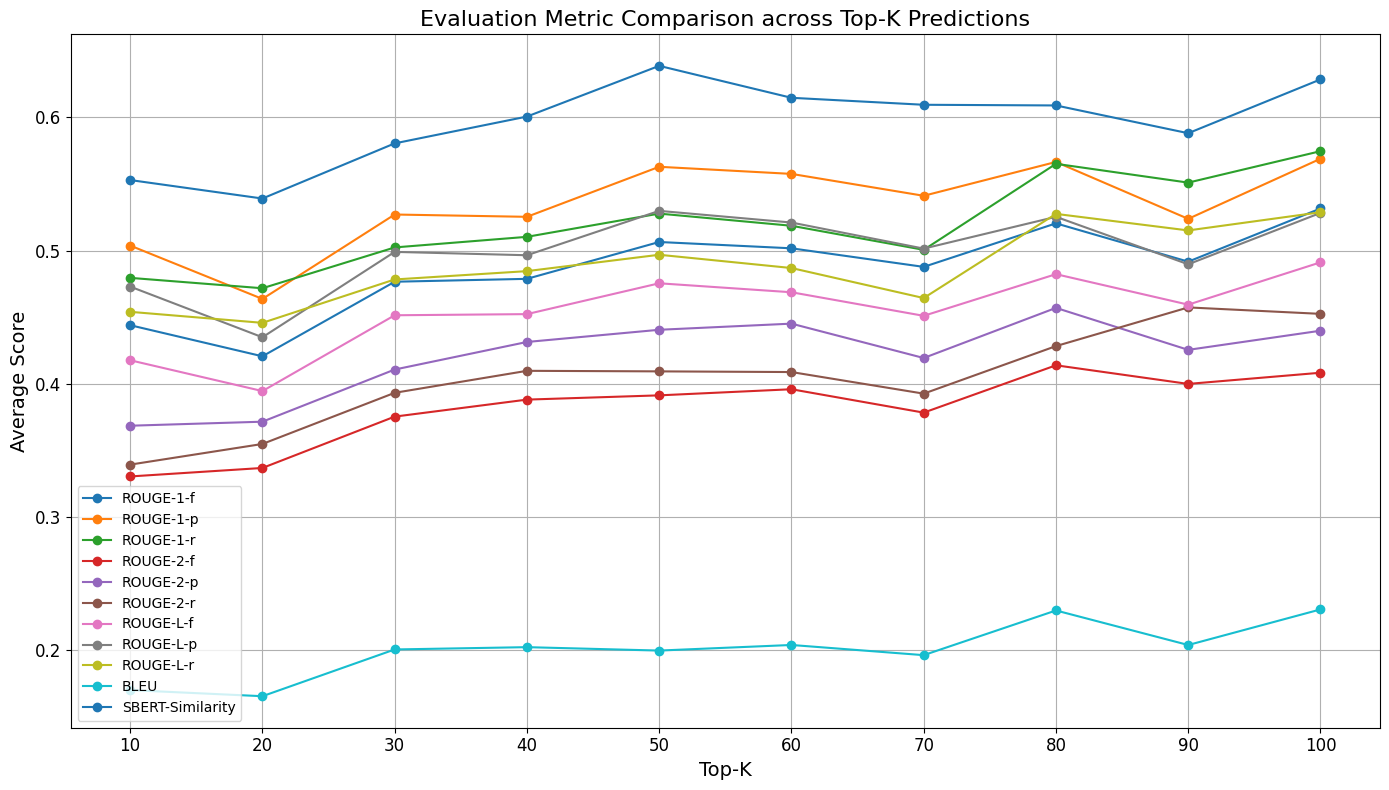

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/MyRAG/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:
    file_name = f"Predicted_Answers_Contexts_FactualTriples_up2_top{top_k}.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_Contexts_FactualTriples_up2_top{top_k}.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    fig_path = os.path.join(base_path, f"Top{top_k}_Evaluation_BarChart_NEW.png")
    plt.savefig(fig_path)
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/MyRAG/Evaluation_Comparison_Averages_NewPrompt.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/MyRAG/Evaluation_Comparison_Averages_NewPrompt.png")
plt.show()